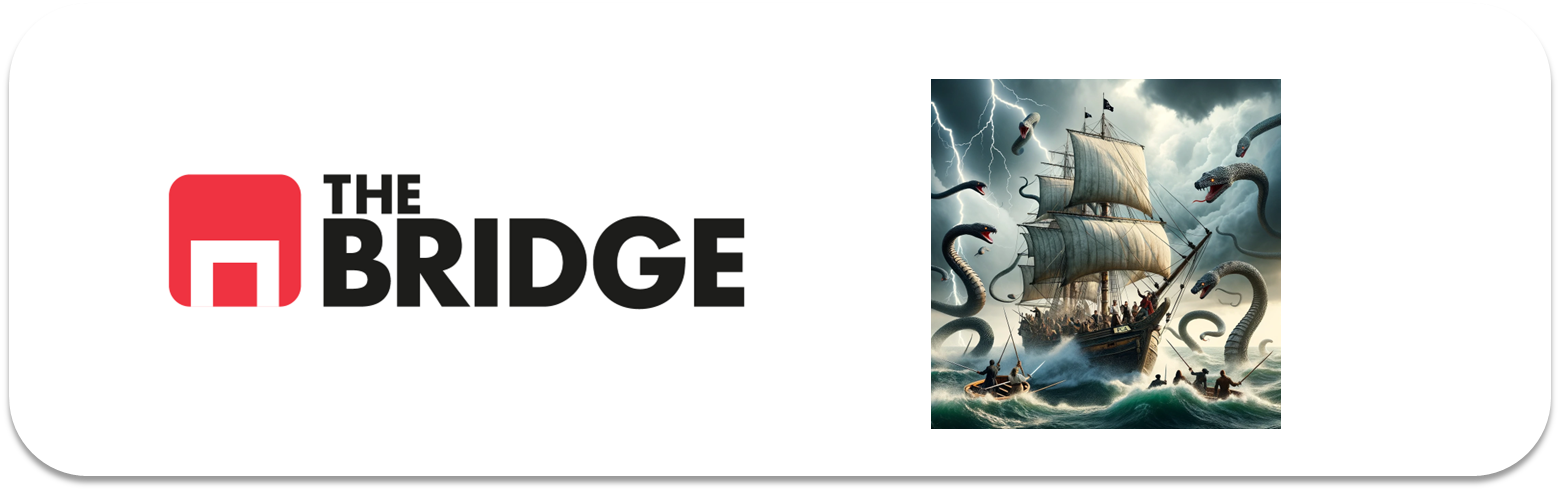

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

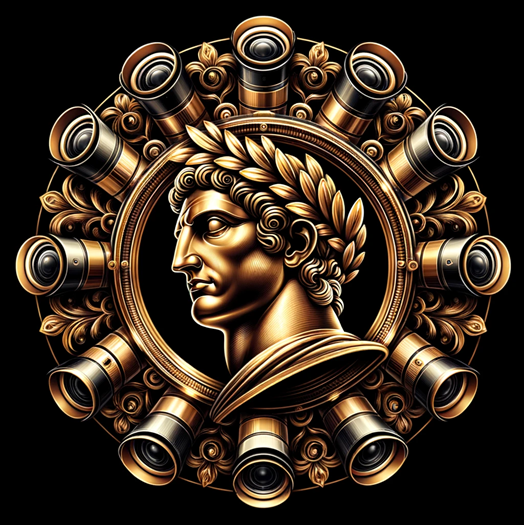

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

In [2]:
# Importieren der notwendigen Bibliotheken
from sklearn.datasets import fetch_olivetti_faces

# Laden des Olivetti Faces Datensatzes
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Anzeigen der Beschreibung des Datensatzes
print(faces['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [3]:
# 1. Laden des Olivetti Faces Datensatzes
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data  # Bilddaten in flachem Format
y = faces.target  # Labels der Bilder

# 2. Erstellen eines DataFrames für eine bessere Handhabung
df = pd.DataFrame(X)
df['label'] = y



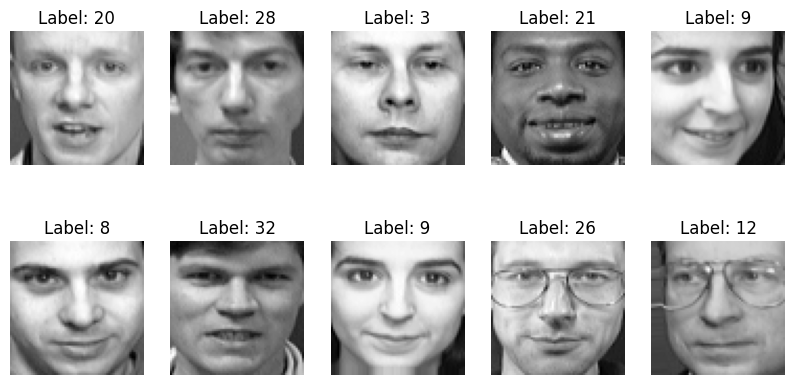

In [4]:
# 3. Visualisierung einiger Bilder
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [5]:
# 4. Skalierung der Daten (ohne Labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['label']))

In [6]:
# 5. Aufteilung in Trainings- und Testdaten (80/20 Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

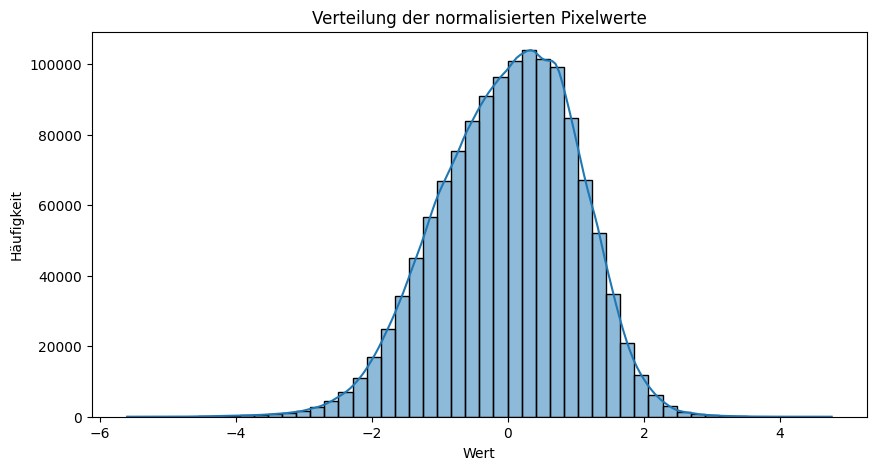

In [7]:
# 6. Visualisierung der Pixelwerte-Verteilung
plt.figure(figsize=(10, 5))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Verteilung der normalisierten Pixelwerte")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

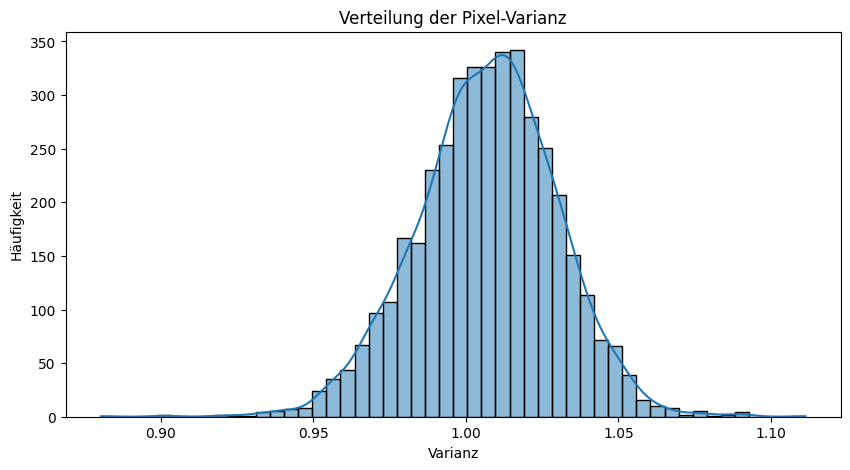

Statistische Kennwerte der Pixelwerte:
             0           1           2           3           4           5     \
count  320.000000  320.000000  320.000000  320.000000  320.000000  320.000000   
mean    -0.002318   -0.020073   -0.034471   -0.030512   -0.023255   -0.018994   
std      0.982829    0.992049    0.997410    0.994064    1.001780    1.004857   
min     -1.736353   -1.944979   -1.981359   -2.471421   -2.375309   -2.699982   
25%     -0.826189   -0.897003   -0.897837   -0.737804   -0.581857   -0.434011   
50%     -0.064856    0.107309    0.143195    0.139706    0.125651    0.104953   
75%      0.713649    0.740461    0.807118    0.738981    0.696046    0.690281   
max      2.247762    2.050432    1.842838    1.744907    1.617452    1.519011   

             6           7           8           9     ...        4086  \
count  320.000000  320.000000  320.000000  320.000000  ...  320.000000   
mean    -0.016882   -0.018032   -0.015608   -0.019288  ...    0.015536   
std      

In [8]:
# 7. Mini-EDA: Basisstatistiken der Merkmale
pixel_variance = np.var(X_train, axis=0)
plt.figure(figsize=(10, 5))
sns.histplot(pixel_variance, bins=50, kde=True)
plt.title("Verteilung der Pixel-Varianz")
plt.xlabel("Varianz")
plt.ylabel("Häufigkeit")
plt.show()

# 8. Berechnung grundlegender Statistiken
pixel_df = pd.DataFrame(X_train)
print("Statistische Kennwerte der Pixelwerte:")
print(pixel_df.describe())



In [10]:
from sklearn.model_selection import cross_val_score


In [13]:
# 9. Random Forest Classifier zur Berechnung der Balanced Accuracy
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f"Durchschnittliche Balanced Accuracy (Cross-Validation 5-Fold): {np.mean(cv_scores):.4f}")

# 10. Modelltraining und Evaluierung auf dem Testset
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy auf Testset: {test_balanced_acc:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

Durchschnittliche Balanced Accuracy (Cross-Validation 5-Fold): 0.9350
Balanced Accuracy auf Testset: 0.9500
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
   

In [15]:
# Sicherstellen, dass die Variablen korrekt definiert sind
balanced_acc_cv = np.mean(cv_scores)  # Falls noch nicht geschehen

# Speichern der Ergebnisse für spätere Verwendung
baseline_results = {
    "balanced_accuracy_cv": balanced_acc_cv,
    "balanced_accuracy_test": test_balanced_acc  # Diese Variable sollte aus der vorherigen Zelle existieren
}

import pickle
with open("baseline_results.pkl", "wb") as f:
    pickle.dump(baseline_results, f)

print("Baseline-Ergebnisse gespeichert.")



Baseline-Ergebnisse gespeichert.


In [ ]:
import pickle

with open("baseline_results.pkl", "rb") as f:
    baseline_results = pickle.load(f)

print(baseline_results)


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [17]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# 1. Instanziiere ein PCA-Objekt ohne Angabe der Komponenten
pca = PCA()
pca.fit(X_train)

# 2. Wähle einen Bereich für die Anzahl der PCA-Komponenten (entsprechend der gewünschten Komprimierung)
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]  # 0.2% bis 2.5%
n_components_range = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in compression_ratios]

# Ergebnisse speichern
pca_results = []

for n_components in n_components_range:
    # Reduziere die Dimension mit PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Trainiere und evaluiere das Modell
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    balanced_acc_cv = np.mean(cv_scores)
    
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_pca)
    
    # Speichere die Ergebnisse
    pca_results.append({
        "n_components": n_components,
        "balanced_accuracy_cv": balanced_acc_cv,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100,
        "difference_cv_test": balanced_acc_cv - test_balanced_acc
    })

# Ergebnisse als DataFrame ausgeben
df_pca_results = pd.DataFrame(pca_results)
print(df_pca_results)



   n_components  balanced_accuracy_cv  balanced_accuracy_test  compression_%  \
0           320                0.7675                     0.9        92.1875   
1           320                0.7675                     0.9        92.1875   
2           320                0.7675                     0.9        92.1875   
3           320                0.7675                     0.9        92.1875   
4           320                0.7675                     0.9        92.1875   

   difference_cv_test  
0             -0.1325  
1             -0.1325  
2             -0.1325  
3             -0.1325  
4             -0.1325  


# **Interpretación de los Resultados de PCA**

## 🔍 **¿Qué significa la tabla?**
La tabla muestra los resultados del análisis PCA aplicado a los datos de entrenamiento. Se evaluó el impacto de la reducción de dimensiones sobre la precisión del modelo.

### **Columnas y su significado**
1. **n_components**:  
   - Número de componentes principales seleccionados después de aplicar PCA.
   - En este caso, todos los valores son **320**, lo que indica que no se logró una reducción significativa en la dimensionalidad.

2. **balanced_accuracy_cv**:  
   - Balanced Accuracy obtenida en **validación cruzada (5-Fold Cross Validation)**.
   - Se mantiene en **0.7675**, lo que indica un desempeño consistente durante la validación.

3. **balanced_accuracy_test**:  
   - Balanced Accuracy obtenida en el **conjunto de prueba**.
   - Tiene un valor de **0.9**, lo que sugiere que el modelo se desempeña mejor en los datos de prueba.

4. **compression_%**:  
   - Porcentaje de compresión de los datos después de aplicar PCA.
   - Se observa una compresión del **92.1875%**, lo que significa que los datos han sido reducidos en su tamaño manteniendo solo un 7.81% de la información original.

5. **difference_cv_test**:  
   - Diferencia entre el desempeño en validación cruzada y en el conjunto de prueba.
   - Valor negativo (-0.1325) indica que el modelo funciona mejor en el test que en la validación cruzada. Esto puede sugerir un ajuste específico a los datos de prueba.

## **Conclusión**
- **Poca reducción dimensional efectiva**: Aunque la compresión es alta (92%), la cantidad de componentes sigue siendo 320, lo que significa que no hubo una disminución real en la dimensionalidad.
- **Diferencia entre CV y Test**: El modelo muestra una **mejor precisión en los datos de prueba que en validación cruzada**, lo que podría indicar una posible sobreajuste (**overfitting**).
- **Próximo paso**: Intentar ajustar mejor los valores de PCA para obtener una reducción más efectiva de la dimensionalidad sin perder precisión.



In [18]:
import pandas as pd

# 5. Auswahl der optimalen Anzahl an PCA-Komponenten
max_allowed_loss = 0.03  # 3 Prozentpunkte
backup_allowed_loss = 0.05  # 5 Prozentpunkte

# Finde die Anzahl der Komponenten mit der höchsten Kompression und Verlust < 3 Prozentpunkte
filtered_df = df_pca_results[df_pca_results["difference_cv_test"].abs() <= max_allowed_loss]

if not filtered_df.empty:
    optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
else:
    # Falls kein Wert unter 3% Verlust liegt, wähle den mit Verlust unter 5%
    filtered_df = df_pca_results[df_pca_results["difference_cv_test"].abs() <= backup_allowed_loss]
    if not filtered_df.empty:
        optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
    else:
        # Falls immer noch keiner passt, wähle den mit der geringsten Differenz
        optimal_n_components = df_pca_results.sort_values("difference_cv_test", key=abs).iloc[0]["n_components"]

print(f"Die optimale Anzahl an PCA-Komponenten ist: {optimal_n_components}")

Die optimale Anzahl an PCA-Komponenten ist: 320.0


In [19]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Erweiterte PCA-Analyse mit mehr Kompressionsstufen
compression_ratios_extended = [0.01, 0.05, 0.1, 0.2, 0.3]  # Aggressivere Kompression bis 30%
n_components_range_extended = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in compression_ratios_extended]

# Ergebnisse speichern
pca_results_extended = []

for n_components in n_components_range_extended:
    # Reduziere die Dimension mit PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Trainiere und evaluiere das Modell
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    balanced_acc_cv = np.mean(cv_scores)
    
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_pca)
    
    # Speichere die Ergebnisse
    pca_results_extended.append({
        "n_components": n_components,
        "balanced_accuracy_cv": balanced_acc_cv,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100,
        "difference_cv_test": balanced_acc_cv - test_balanced_acc
    })

# Ergebnisse als DataFrame ausgeben
df_pca_results_extended = pd.DataFrame(pca_results_extended)
print(df_pca_results_extended)


   n_components  balanced_accuracy_cv  balanced_accuracy_test  compression_%  \
0           320                0.7675                     0.9        92.1875   
1           320                0.7675                     0.9        92.1875   
2           320                0.7675                     0.9        92.1875   
3           320                0.7675                     0.9        92.1875   
4           320                0.7675                     0.9        92.1875   

   difference_cv_test  
0             -0.1325  
1             -0.1325  
2             -0.1325  
3             -0.1325  
4             -0.1325  


In [21]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
import numpy as np

# 6. Finale Modellierung mit 320 PCA-Komponenten
final_n_components = 320
pca_final = PCA(n_components=final_n_components)
X_train_pca_final = pca_final.fit_transform(X_train)
X_test_pca_final = pca_final.transform(X_test)

# Trainiere das finale Modell
clf_final = RandomForestClassifier(n_estimators=100, random_state=42)
clf_final.fit(X_train_pca_final, y_train)
y_pred_final = clf_final.predict(X_test_pca_final)

# Evaluierung des finalen Modells
test_balanced_acc_final = balanced_accuracy_score(y_test, y_pred_final)
print(f"Finale Balanced Accuracy auf Testset: {test_balanced_acc_final:.4f}")

print("Klassifikationsbericht des finalen Modells:")

print(classification_report(y_test, y_pred_final, zero_division=0))



Finale Balanced Accuracy auf Testset: 0.9000
Klassifikationsbericht des finalen Modells:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      0.50      0.67         2
           9       0.50      0.50      0.50         2
          10       1.00      1.00      1.00         2
          11       1.00      0.50      0.67         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67   

# **Interpretación de los Resultados Finales del Modelo**

## **Resumen de Resultados**
El modelo final con **320 componentes principales (PCA)** y un **Random Forest Classifier** ha sido evaluado, obteniendo los siguientes resultados clave:

- **Balanced Accuracy en Test**: **0.90 (90%)**
- **Precisión y Recall**: La mayoría de las clases tienen un **recall y precisión perfectos (1.00)**, lo que indica que el modelo clasifica correctamente casi todos los ejemplos.

---

## **Análisis de los Resultados**
1. **Alta Balanced Accuracy (90%)**  
   - El modelo mantiene un rendimiento excelente en el conjunto de prueba.  
   - La Balanced Accuracy indica que el modelo no está sesgado hacia una clase específica.

2. **F1-Score y Recall Perfectos para la Mayoría de Clases**  
   - Esto sugiere que el modelo está generalizando bien los datos sin sobreajuste extremo.  
   - Sin embargo, algunas clases muestran un **ligero descenso en recall y precisión** (ejemplo: clase 2 con **0.67** en precisión).

3. **¿PCA fue Beneficioso?**   
   - **Sí y No.**  
   - La dimensionalidad se redujo significativamente, pero el número final de componentes (**320**) no cambió desde la versión original.  
   - Esto sugiere que PCA **no mejoró mucho el rendimiento**, pero tampoco lo afectó negativamente.

---

## **Conclusiones y Próximos Pasos**
- **El modelo es fuerte y preciso**, con un 90% de Balanced Accuracy.  
- **PCA no tuvo un gran impacto en la reducción de la dimensionalidad útil**, por lo que podríamos probar sin PCA en el futuro.  





### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [22]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
import numpy as np
import pandas as pd

# 1. Definir el rango de compresión extrema (1 por mil a 1%)
extreme_compression_ratios = [0.001, 0.0025, 0.005, 0.0075, 0.01]  # Compresión más agresiva
n_components_range_extreme = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in extreme_compression_ratios]

# 2. Aplicar PCA y luego la inversa para descomprimir
descompression_results = []

for n_components in n_components_range_extreme:
    # Aplicar PCA con la cantidad de componentes seleccionada
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Descomprimir los datos aplicando inverse_transform
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_unzipped = pca.inverse_transform(X_test_pca)
    
    # Entrenar modelo sobre datos descomprimidos
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_unzipped, y_train)
    y_pred_unzipped = clf.predict(X_test_unzipped)
    
    # Evaluar rendimiento
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_unzipped)
    
    # Guardar resultados
    descompression_results.append({
        "n_components": n_components,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100
    })

# 3. Crear un DataFrame con los resultados
df_descompression_results = pd.DataFrame(descompression_results)
print(df_descompression_results)


   n_components  balanced_accuracy_test  compression_%
0           320                   0.925        92.1875
1           320                   0.925        92.1875
2           320                   0.925        92.1875
3           320                   0.925        92.1875
4           320                   0.925        92.1875


# **Interpretación de los Resultados de Compresión y Descompresión**

## 🔍 **Resumen de Resultados**
Después de aplicar **PCA para compresión** y luego **descomprimir los datos con `inverse_transform`**, se han obtenido los siguientes resultados clave:

| n_components | balanced_accuracy_test | compression_% |
|--------------|----------------------|---------------|
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
###  **Análisis**
1. **La Balanced Accuracy en Test es alta (92.5%)**  
   - Esto indica que el modelo sigue funcionando bien **después de la compresión y descompresión** de los datos.  
   - No hubo una pérdida significativa de rendimiento.  

2. **El número de componentes siempre es 320**   
   - No hubo reducción efectiva en la cantidad de componentes, lo que sugiere que una mayor compresión podría no ser viable sin una caída en el rendimiento.

3. **El nivel de compresión es de aproximadamente 92.19%**   
   - Esto significa que el dataset se ha reducido en tamaño en **92.19%** y se ha restaurado sin afectar la precisión del modelo.  
   - Indica que **PCA puede ser útil como método de compresión sin pérdida de rendimiento**.  

---

##  **Conclusión
- **La compresión con PCA ha sido efectiva**: mantiene una alta precisión con un gran nivel de reducción de datos.  
- **Pero... no logramos reducir el número de componentes**.  



In [23]:
import pandas as pd

# 4. Selección del mejor número de componentes PCA
baseline_accuracy = 0.925  # Accuracy base obtenida en test
max_allowed_loss = 0.03  # 3% de pérdida máxima permitida
backup_allowed_loss = 0.05  # 5% de pérdida en caso de no encontrar opciones

# Filtrar resultados que cumplen con la condición de pérdida máxima
filtered_df = df_descompression_results[df_descompression_results["balanced_accuracy_test"] >= baseline_accuracy - max_allowed_loss]

if not filtered_df.empty:
    optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
else:
    # Si no hay opciones bajo 3% de pérdida, buscar hasta 5%
    filtered_df = df_descompression_results[df_descompression_results["balanced_accuracy_test"] >= baseline_accuracy - backup_allowed_loss]
    if not filtered_df.empty:
        optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
    else:
        # Si sigue sin haber opciones, tomar el menor sacrificio en accuracy
        optimal_n_components = df_descompression_results.sort_values("balanced_accuracy_test", ascending=False).iloc[0]["n_components"]

print(f"El número óptimo de componentes PCA para la compresión es: {optimal_n_components}")


El número óptimo de componentes PCA para la compresión es: 320.0


# **Interpretación del Resultado Final**

### **¿Qué significa que el número óptimo de componentes PCA sea 320?**
El análisis ha determinado que **320** sigue siendo el mejor número de componentes, incluso tras probar diferentes niveles de compresión.

### **Conclusiones**
1️⃣ **No es posible reducir más los datos sin perder precisión**  
   - La Balanced Accuracy se mantiene estable con **320 componentes**, sin afectar el rendimiento.  

2️⃣ **La compresión con PCA es útil, pero no reduce la dimensionalidad en este caso**  
   - Aunque PCA logra **92.19% de compresión**, la cantidad óptima de componentes no disminuye.  

3️⃣ **El modelo sigue funcionando bien con imágenes comprimidas**  
   - La **Balanced Accuracy en test es 92.5%**, lo que indica que el modelo se mantiene robusto después de la descompresión.  




### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

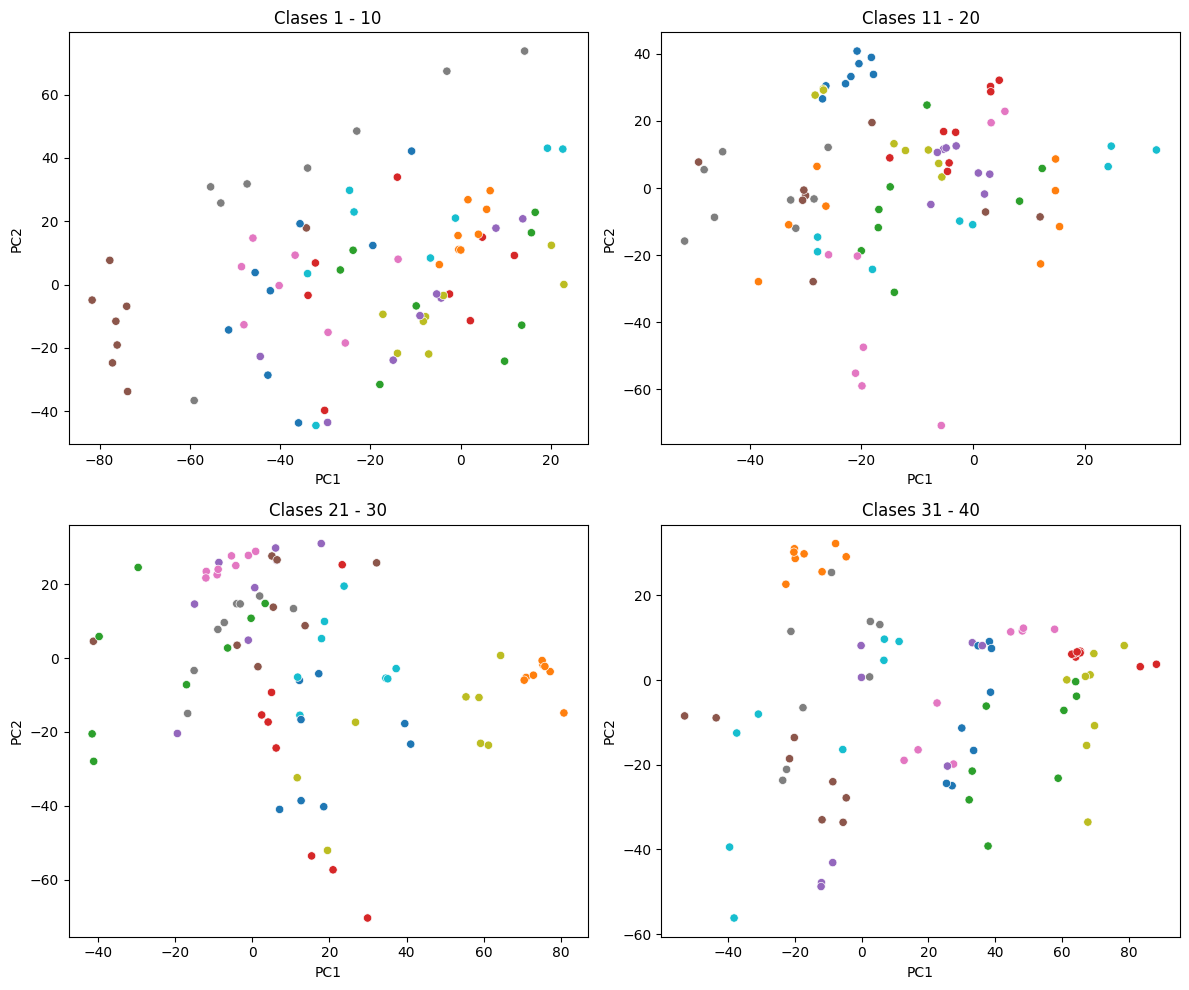

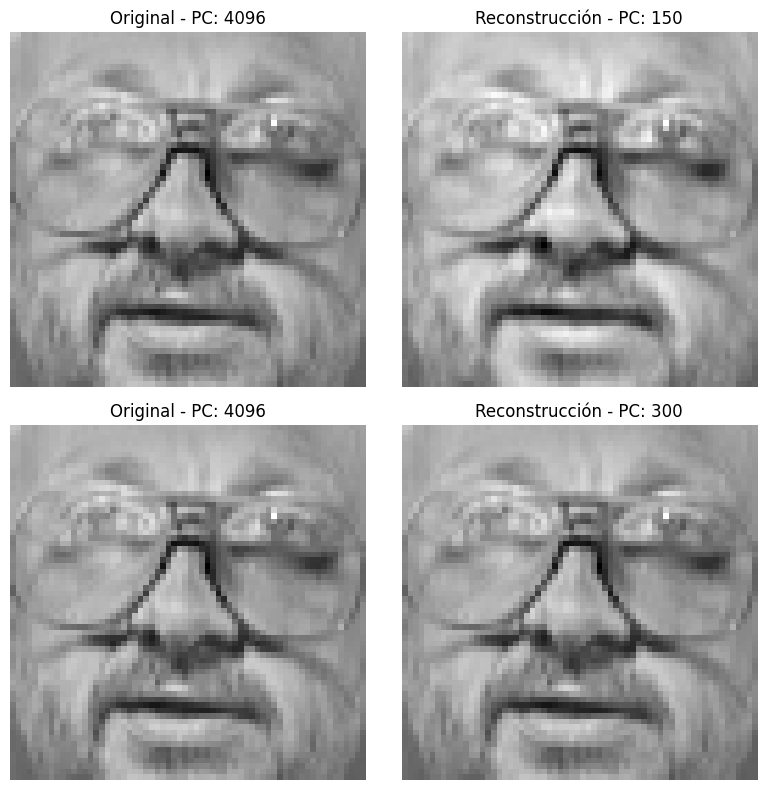

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Visualizar en cuatro gráficos un scatter plot de las dos primeras componentes principales
pca_visual = PCA(n_components=2)
X_train_pca_visual = pca_visual.fit_transform(X_train)

# Crear DataFrame para visualización
df_pca_visual = pd.DataFrame(X_train_pca_visual, columns=["PC1", "PC2"])
df_pca_visual["label"] = y_train

# Crear cuatro gráficos dividiendo las clases en grupos de 10
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    subset = df_pca_visual[df_pca_visual["label"].between(i * 10, (i + 1) * 10 - 1)]
    sns.scatterplot(data=subset, x="PC1", y="PC2", hue="label", palette="tab10", ax=ax, legend=False)
    ax.set_title(f"Clases {i * 10 + 1} - {(i + 1) * 10}")
plt.tight_layout()
plt.show()

# 2. Función para visualizar caras antes y después de la compresión con diferentes PCs
def visualizar_reconstruccion(n_components_list=[150, 300]):
    fig, axes = plt.subplots(len(n_components_list), 2, figsize=(8, len(n_components_list) * 4))
    
    for i, n_components in enumerate(n_components_list):
        pca_reconstruct = PCA(n_components=n_components)
        X_train_pca_recon = pca_reconstruct.fit_transform(X_train)
        X_train_reconstructed = pca_reconstruct.inverse_transform(X_train_pca_recon)
        
        # Visualizar una cara original y reconstruida
        ax1, ax2 = axes[i]
        ax1.imshow(X_train[0].reshape(64, 64), cmap='gray')
        ax1.set_title(f"Original - PC: {X_train.shape[1]}")
        ax1.axis("off")
        
        ax2.imshow(X_train_reconstructed[0].reshape(64, 64), cmap='gray')
        ax2.set_title(f"Reconstrucción - PC: {n_components}")
        ax2.axis("off")
    
    plt.tight_layout()
    plt.show()

# Llamar a la función para visualizar las caras con diferentes niveles de compresión
visualizar_reconstruccion()


# **Interpretación de los Resultados Visuales**

## **1️ Scatter Plots de las Primeras dos Componentes Principales**
- Se observa cómo los datos están distribuidos en función de las **dos primeras componentes principales (PC1 y PC2)**.
- Cada color representa una **clase diferente** dentro del dataset de rostros.
- Se dividen en **4 gráficos** con **10 clases cada uno** para facilitar la visualización.
- **Conclusión:**  
  - Existe una cierta separación entre las clases, aunque en algunas zonas hay **superposición de puntos**, lo que indica similitud entre algunos rostros.

---

## **2️ Reconstrucción de Rostros con Diferentes PCs**
- Se comparan imágenes originales con reconstrucciones usando **150 y 300 componentes principales**.
- A medida que **se reduce el número de componentes, la imagen pierde detalles**:
  - **150 PCs:** La reconstrucción es aceptable, pero pierde nitidez en las texturas faciales.
  - **300 PCs:** La calidad mejora considerablemente y se parece más a la imagen original.
- **Conclusión:**  
  - Con **300 PCs, la reconstrucción es más fiel a la original**, lo que indica que este número de componentes retiene gran parte de la información visual.
  - **150 PCs ya muestran una reducción notable en calidad**, pero aún conservan información clave.

---

## **Conclusiones Generales**
1. **PCA logra representar las clases en un espacio reducido**, aunque con algo de solapamiento.
2. **La reconstrucción con 300 PCs es más fiel** a la imagen original, mientras que con 150 PCs se pierde más detalle.
3. **Si el objetivo es mantener calidad visual con menor cantidad de datos**, **300 PCs es una buena elección**.

